In [273]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
 
%matplotlib inline
%load_ext autoreload
%autoreload 2
 
from os.path import join as pjoin
import glob
import numpy as np
from numpy import hstack as stack
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['image.cmap'] = 'inferno'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
# Retail sales of beer, wine and liquor in the U.S.
# Monthly data from January 1992 till November 2017
BeerWine = pd.read_csv('data/BeerWineUS.csv', header=0, index_col=0,
                       squeeze=True)

# Real (inﬂation corrected) interest rate for bank deposits with
# investment durations between one and two years
interestrate = pd.read_csv('data/interestrate.csv', sep=';',
                           index_col=0, header=None).iloc[:,0]
interestrate = interestrate.map(lambda s: float(s.replace(',', '.')))

# Crude oil price per barrel
CrudeOil = pd.read_csv('data/CrudeOil.csv', header=0, index_col=0, squeeze=True)

# 3

Simple forecasting and forecasting with exponential smoothing with `BeerWineUS.csv`. Begin the forecasting starting with the observation 201. Thus the out-of-sample performance of the below methods will be assessed using the forecasts for the periods 201 to 311.

In [291]:
def show_series(train, test, test_df=None):
    if isinstance(test, np.ndarray):
        assert test_df is not None
        test = pd.Series(test, index=test_df.index)
    minv = stack((train.values, test.values)).min()
    maxv = stack((train.values, test.values)).max()
    plt.plot(train.index, train.values, label='train', color='C0')
    plt.vlines(train.index[-1], min(0, minv), maxv, 'gray', '--')
    plt.plot(test.index, test.values, label='test', color='C1')
    if len(test) == 1:
        plt.scatter(test.index, test.values, color='C1')
    plt.legend()
    plt.xticks(stack((train.index, test.index))[::50])
    plt.yticks(stack(np.linspace(min(0, minv), maxv, 10)))
#     plt.show()

def split_ts(series, n_train):
    train = series.iloc[:n_train]
    test = series.iloc[n_train:]
    n_test = len(test)
    print('{}: {} + {}'.format(N, n_train, n_test))
    show_series(train, test)
    return train, test, n_test

311: 201 + 110


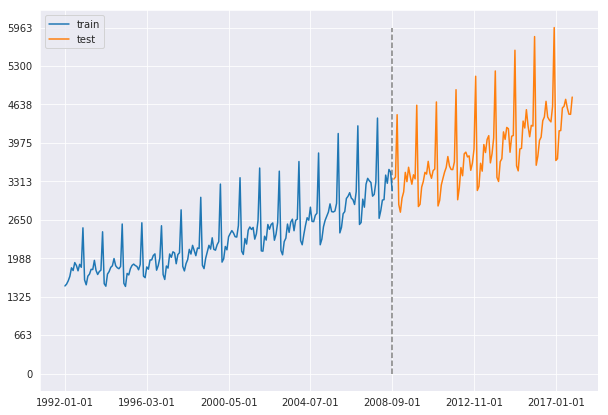

In [292]:
mpl.rcParams['figure.figsize'] = (10,7)
N = len(BeerWine)
n_train = 201
train, test, n_test = split_ts(BeerWine, n_train)

In [197]:
def MA(train, test, k=10):
    n_test = len(test)
    forecast_values = []
    for i in range(n_test):
        train_k = stack((train.values[n_train-k+i:], forecast_values[max(i-k,0):i]))
        forecast_values.append(train_k.mean())
    return pd.Series(forecast_values, index=test.index)

def EWMA(train, test, alpha=0.5):
    n_train, n_test = len(train), len(test)
    forecast_values = [train.values[0]]
    for i in range(1,n_train):
        forecast_values.append(alpha * train.values[i-1] + (1 - alpha) * forecast_values[i-1])
    forecast_values.extend([forecast_values[-1]]*n_test)
    return pd.Series(forecast_values, index=stack((train.index, test.index)))

def Holt(train, test, alpha=0.3, beta=0.4):
    level, trend = [train.values[0]], [0]
    for i in range(1, n_train):
        level.append(alpha * train.values[i] + (1- alpha) * (level[i-1] + trend[i-1]))
        trend.append(beta * (level[i] - level[i-1]) + (1- beta) * trend[i-1])
#     forecast_values = level[-1] + trend[-1] * np.arange(n_test)
#     return pd.Series(forecast_values, index=test.index)
    forecast_values = stack((level, level[-1] + trend[-1] * np.arange(n_test)))
    return pd.Series(forecast_values, index=stack((train.index, test.index)))

def HoltWinters(train, test, alpha=0.3, beta=0.4, gamma=0.1, s=1):
    n_test = len(test)
    level, trend, season = [train.values[0]], [0], [0]
    for i in range(1, n_train):
        level.append(alpha * train.values[i] + (1- alpha) * (level[i-1] + trend[i-1]))
        trend.append(beta * (level[i] - level[i-1]) + (1- beta) * trend[i-1])
        season.append(gamma * (train.values[i] - level[i]) + (1 - gamma) * season[max(i-s, 0)])
#     forecast_values = level[-1] + trend[-1] * np.arange(n_test)
#     return pd.Series(forecast_values, index=test.index)
    S = level[-1] + trend[-1] * np.arange(n_test) + \
        stack((np.repeat([season[-s:]], n_test // s, 0).flatten(),
              season[:n_test % s]))
    forecast_values = stack((level + stack((np.zeros(s), season[:-s])), S))
    return pd.Series(forecast_values, index=stack((train.index, test.index)))

(a) Compute forecasts using simple EWMA, Holt and Holt-Winters forecasts with the smoothing parameters calibrated from the ﬁrst 200 observations.

In [198]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

forecasts = {}

# EWMA
ewma = ExponentialSmoothing(train, trend=None, damped=False, seasonal=None)
forecast_values = ewma.predict(ewma.fit().params,
                               start='1992-01-01', end='2017-11-01')
ewma_result = pd.Series(forecast_values, index=BeerWine.index)
forecasts['EWMA'] = ewma_result.iloc[n_train:]

# Holt
holt = ExponentialSmoothing(train, trend='add', damped=False, seasonal=None)
forecast_values = holt.predict(holt.fit().params,
                               start='1992-01-01', end='2017-11-01')
holt_result = pd.Series(forecast_values, index=BeerWine.index)
forecasts['Holt'] = holt_result.iloc[n_train:]

# Holt-Winters
holtWinters = ExponentialSmoothing(train, trend='add', damped=False,
                                   seasonal='mul', seasonal_periods=12)
forecast_values = holtWinters.predict(holtWinters.fit().params,
                                      start='1992-01-01', end='2017-11-01')
holtWinters_result = pd.Series(forecast_values, index=BeerWine.index)
forecasts['Holt-Winters'] = holtWinters_result.iloc[n_train:]

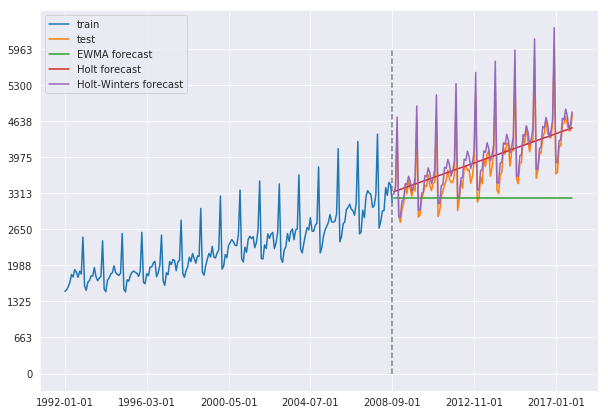

In [199]:
keys = ['EWMA', 'Holt', 'Holt-Winters']

show_series(train, test)

for k in keys:
    plt.plot(forecasts[k], label='{} forecast'.format(k))

plt.legend()
plt.show()

(b) Compute the corresponding MSE losses. Check the ACF of the forecast errors.

In [200]:
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.stattools import acf

print('\tEWMA\t\tHolt\t\tHolt-Winters')
print('MSE:\t{:.1f}\t{:.1f}\t{:.1f}'.format(MSE(test, forecasts['EWMA']),
                                            MSE(test, forecasts['Holt']),
                                            MSE(test, forecasts['Holt-Winters'])))

	EWMA		Holt		Holt-Winters
MSE:	791343.8	234909.3	38023.6


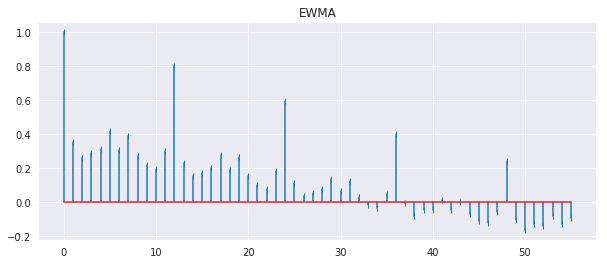

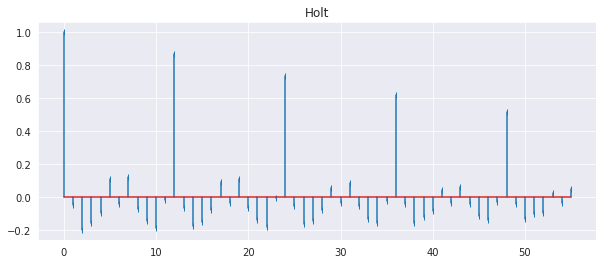

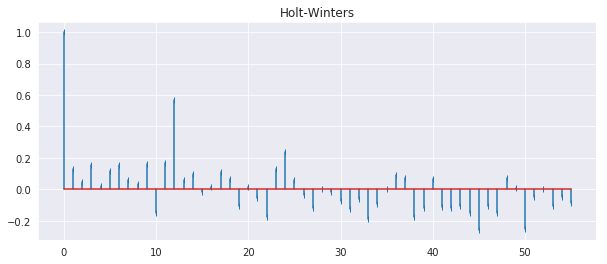

In [213]:
mpl.rcParams['figure.figsize'] = (10,4)
def ACF(y, y_pred=None, nlags=None, alpha=0.05, title=''):
    if y_pred is not None:
        y = y - y_pred
    nlags = len(y)//2 if nlags is None else nlags
    acfs, confs = acf(y, nlags=nlags, alpha=alpha)
#     plt.plot(confs[:,0], 'k--')
#     plt.plot(confs[:,1], 'k--')
    plt.stem(acfs, markerfmt='|')
    plt.title(title)
    plt.show()
    
for k in keys:
    ACF(test, forecasts[k], title=k)

(c) Compare the performance of the models using the three tests discussed in the lectures.

In [66]:
from scipy import stats
from dm_test import dm_test

def normal_cdf(x):
    return stats.norm().cdf(x)

def normal_ppf(F):
    return stats.norm().ppf(F)

def two_sided_Z_test(x, a, sigma=None, alpha=None, out=True):
    '''
    H0: mean == a
    H1: mean != a
    alpha -- significance level
    '''
    if out:
        print('\nTwo-sided Z-test {}'.format('(sigma is unknown)' if sigma is None else ''))
        print('H0: mean == {}'.format(a))
        print('H1: mean != {}'.format(a))
    n = len(x)
    sample_mean = np.mean(x)
    if sigma is None:
        sample_var = np.var(x, ddof=1)
        v = (sample_mean - a) * np.sqrt(n) / np.sqrt(sample_var)
        p_value = 2 * student_cdf(n-1, v) if v < 0 else 2 * (1 - student_cdf(n-1, v))
        if alpha is not None:
            t_crit = student_ppf(n-1, 1-alpha/2)
    else:
        v = (sample_mean - a) * np.sqrt(n) / sigma
        p_value = 2 * normal_cdf(v) if v < 0 else 2 * (1 - normal_cdf(v))
        if alpha is not None:
            t_crit = normal_ppf(1-alpha/2)
            
    if out:
        print('p-value is {:.6f}. For all α > {:.6f} we can reject H0.'.format(p_value, p_value))
    if alpha is not None:
        rejected = v < -t_crit or v > t_crit
        if out:
            print('The rejection area is: (-inf, -{:.3f}) ∪ ({:.3f}, inf)'.format(t_crit, t_crit))
            print('t_stat = {:.3f} is {}in the rejection area.'.format(v, '' if rejected else 'not '))
            if not rejected:
                print('With significance level α={} we cannot reject H0.'.format(alpha, a))
            else:
                print('With significance level α={} we reject H0.'.format(alpha, a))
        return p_value, rejected

    return p_value

def one_sided_Z_test(x, a, sigma=None, alpha=None, left=False, out=True):
    '''
    H0: mean >= a
    H1: mean < a
    alpha -- significance level
    '''
    side = 'left' if left else 'right'
    if out:
        print('\nOne ({})-sided Z-test {}'.format(side, '(sigma is unknown)' if sigma is None else ''))
        print('H0: mean {}= {}'.format('>' if left else '<',a))
        print('H1: mean {} {}'.format('<' if left else '>',a))
    n = len(x)
    sample_mean = np.mean(x)
    if out:
        print('Sample mean: {:.3f}'.format(sample_mean))
    if sigma is None:
    # Unknown deviation
        sample_var = np.var(x, ddof=1)
        # Test statistic ~ St
        v = (sample_mean - a) * np.sqrt(n) / np.sqrt(sample_var)
        p_value = student_cdf(n-1, v) if left else (1 - student_cdf(n-1, v))
        if alpha is not None:
            t_crit = student_ppf(n-1, 1-alpha)
    else:
    # Known deviation
        # Test statistic ~ N(0, 1)
        v = (sample_mean - a) * np.sqrt(n) / sigma
        p_value = normal_cdf(v) if left else (1 - normal_cdf(v))
        if alpha is not None:
            t_crit = normal_ppf(1-alpha)
            
    if out:
        print('p-value is {:.2E}. For all α > {:.2E} we can reject H0.'.format(p_value, p_value))
    if alpha is not None:
        rejected = v < -t_crit if left else v > t_crit
        if out:
            reg_area = '(-inf, -{:.3f})'.format(t_crit) if left else '({:.3f}, inf)'.format(t_crit)
            print('The rejection area is: {}'.format(reg_area))
            print('t_stat = {:.3f} is {}in the rejection area.'.format(v, '' if rejected else 'not '))
            if not rejected:
                print('With significance level α={} we cannot reject H0.'.format(alpha, a))
            else:
                print('With significance level α={} we reject H0.'.format(alpha, a))
        return p_value, rejected
    return p_value


# from statsmodels.stats.descriptivestats import sign_test
# from scipy.stats import wilcoxon

loss_fn = lambda y, y_pred: (y - y_pred)**2

def EPA_sign(test, f1, f2, alpha=None): 
    d = loss_fn(test, f1) - loss_fn(test, f2)
    N = len(d)
    sample = (d > 0).astype(np.float)
    mean, std = 0.5, 0.5
    pvalue = one_sided_Z_test(sample, mean, std, alpha, left=False, out=False)
    stats.ttest_1samp(sample, mean)
    print('p-value is {:.2E}. For all α > {:.2E} we can reject H0.'.format(pvalue, pvalue))
    if pvalue < 0.05:
        print('Since the p-value is very small, we see that the {} model is better than {}.'.format(k2, k1))
        
def EPA_Wilcoxon(test, f1, f2, alpha=None): 
    d = loss_fn(test, f1) - loss_fn(test, f2)
    N = len(d)
    ranks = stats.rankdata(np.abs(d))
    sample = (d > 0).astype(np.float) * ranks
    mean = (N + 1) / 4
    std = np.sqrt((N+1) * (2 * N + 1) / 24)
    pvalue = one_sided_Z_test(sample, mean, std, alpha, left=False, out=False)
#     pvalue = wilcoxon(d).pvalue / 2 
    print('p-value is {:.2E}. For all α > {:.2E} we can reject H0.'.format(pvalue, pvalue))
    if pvalue < 0.05:
        print('The p-value is very small, so the {} model is much better than {}.'.format(k2, k1))
        
def EPA_Diebold_Mariano(test, f1, f2, alpha=None): 
    pvalue = dm_test(test, f1, f2).p_value
#     d = loss_fn(test, f1) - loss_fn(test, f2)
#     N = len(d)
#     M = np.ceil(N**(1/3))
#     d_mean = np.mean(d)
#     gamma = [np.sum((d - d_mean)[int(abs(i)):]*(d - d_mean)[:N-int(abs(i))])/N for i in np.arange(-M, M+1)]
#     std = np.sqrt(np.sum(gamma))
#     pvalue = one_sided_Z_test(d, 0, std, alpha, left=False, out=False)
    print('p-value is {:.2E}. For all α > {:.2E} we can reject H0.'.format(pvalue, pvalue))
    if pvalue < 0.05:
        print('The p-value is very small, so the {} model is better than {}.'.format(k2, k1))
        

In [67]:
from itertools import combinations
from dm_test import dm_test

print('Comparing the performance with 3 tests')
print('Diff. is [model 1] - [model 2]')
alpha = None
for (k1,k2) in combinations(keys, 2):
    f1, f2 = forecasts[k1], forecasts[k2]
    print('================================\nmodel 1: {}\nmodel 2: {}'.format(k1, k2))
    print('\n1. Sign test')
    EPA_sign(test, f1, f2, alpha)
    print('\n2. Wilcoxon sign test')
    EPA_Wilcoxon(test, f1, f2, alpha)
    print('\n3. Diebold-Mariano test')
    EPA_Diebold_Mariano(test, f1, f2, alpha)
#     print(dm_test(test, f1, f2))

Comparing the performance with 3 tests
Diff. is [model 1] - [model 2]
model 1: EWMA
model 2: Holt

1. Sign test
p-value is 9.33E-07. For all α > 9.33E-07 we can reject H0.
Since the p-value is very small, we see that the Holt model is better than EWMA.

2. Wilcoxon sign test
p-value is 1.95E-08. For all α > 1.95E-08 we can reject H0.
The p-value is very small, so the Holt model is much better than EWMA.

3. Diebold-Mariano test
p-value is 1.70E-08. For all α > 1.70E-08 we can reject H0.
The p-value is very small, so the Holt model is better than EWMA.
model 1: EWMA
model 2: Holt-Winters

1. Sign test
p-value is 5.55E-16. For all α > 5.55E-16 we can reject H0.
Since the p-value is very small, we see that the Holt-Winters model is better than EWMA.

2. Wilcoxon sign test
p-value is 0.00E+00. For all α > 0.00E+00 we can reject H0.
The p-value is very small, so the Holt-Winters model is much better than EWMA.

3. Diebold-Mariano test
p-value is 4.28E-09. For all α > 4.28E-09 we can reject 

# 4

ARMA modelling with `interestrate.csv`. Keep the last year for forecasting.

178: 177 + 1


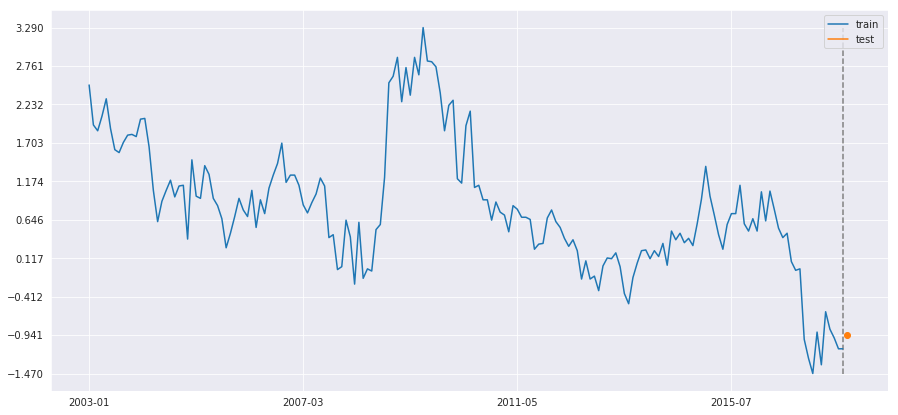

In [294]:
mpl.rcParams['figure.figsize'] = (15,7)

N = len(interestrate)
n_train = N-1
train, test, n_test = split_ts(interestrate, n_train)

(a) Check the ACF and decide about the strength of the memory in the time series using Box-Ljung/Pierce tests.

In [295]:
# def acff(Y, h):
#     Y = np.array(Y)
#     N = len(Y)
#     M = Y.mean()
#     cov = ((Y[:N-h] - M)*(Y[h:] - M)).sum() / N
#     return cov / Y.var(ddof=0)

# def ACFF(Y, nlags=None):
#     if nlags is None:
#         nlags = len(Y)
#     acfs = np.array([acff(Y, h) for h in range(nlags)])
#     return acfs

# acfs = ACFF(train, 100)
# plt.stem(acfs, markerfmt='|')
# plt.show()

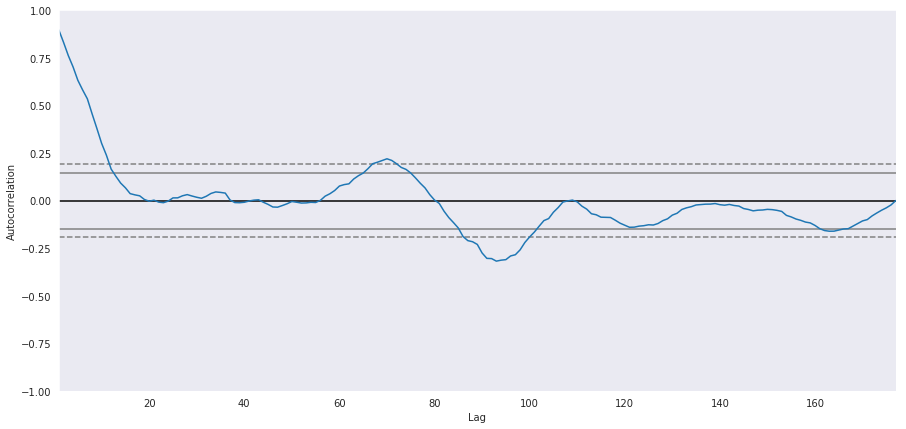

Box-Ljung test:


array([2.45420971e-033, 2.66995414e-059, 4.91326254e-081, 1.88801804e-099,
       2.84784824e-114, 9.58496923e-127, 3.35105329e-137, 1.43500278e-144,
       2.05461322e-149, 3.97769468e-152, 1.63937080e-153, 1.03741757e-153,
       1.79684957e-153, 6.25500711e-153, 3.05068073e-152, 1.94634032e-151,
       1.25144391e-150, 8.00851728e-150, 5.26986354e-149, 3.37861181e-148,
       2.11157342e-147, 1.27892089e-146, 7.51908731e-146, 4.37296402e-145,
       2.44272886e-144, 1.33531656e-143, 6.85311019e-143, 3.32637635e-142,
       1.65248870e-141, 8.29243467e-141, 4.15484780e-140, 1.97173387e-139,
       8.37549129e-139, 3.26688253e-138, 1.28358263e-137, 5.12682000e-137,
       2.37749620e-136, 1.07490894e-135, 4.78534296e-135, 2.11359374e-134,
       9.29370650e-134, 4.03707361e-133, 1.73012873e-132, 7.27413694e-132,
       2.91295119e-131, 1.05966857e-130, 3.77838846e-130, 1.41606063e-129,
       5.50004179e-129, 2.17897473e-128, 8.49323432e-128, 3.23991253e-127,
       1.22656903e-126, 4

In [296]:
from pandas.tools.plotting import autocorrelation_plot

# ACF(train)
autocorrelation_plot(train)
plt.show()
print('Box-Ljung test:')
_, qstat, pvalue = acf(train, nlags=len(train)//2, qstat=True)
qstat
pvalue

(b) Try `MA(1)`, `AR(1)` and `ARMA(1,1)` processes and check the ﬁt (ACF of residuals, AIC, etc.)


MA(1):
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  177
Model:                     ARMA(0, 1)   Log Likelihood                -163.730
Method:                       css-mle   S.D. of innovations              0.609
Date:                Tue, 12 Feb 2019   AIC                            333.459
Time:                        11:03:05   BIC                            342.988
Sample:                             0   HQIC                           337.323
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8134      0.078     10.404      0.000       0.660       0.967
ma.L1.y        0.7118      0.042     17.087      0.000       0.630       0.793
                                    Roots   

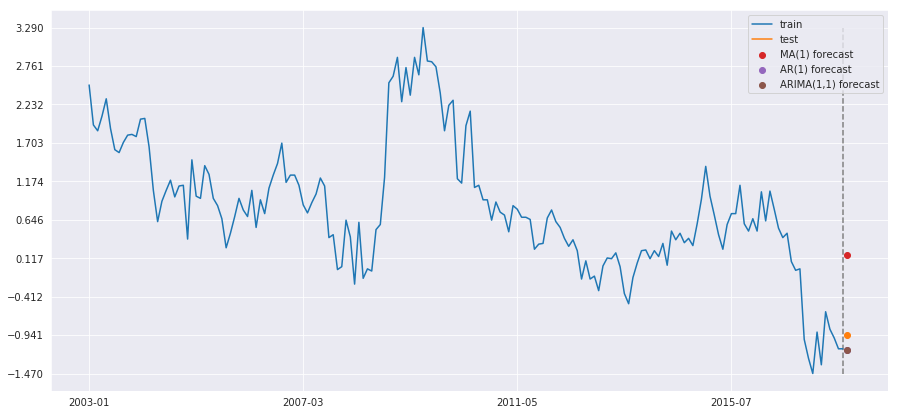

In [318]:
from statsmodels.tsa.arima_model import ARIMA
# import pyflux as pf
# model = pf.ARIMA(pd.DataFrame(train),0,1)
# model.fit('MLE').summary()
show_series(train, test)

model_name = 'MA(1)'
print('\n{}:'.format(model_name))
model = ARIMA(np.array(train), order=(0,0,1)).fit()
print(model.summary())
forecast, _, _ = model.forecast(1)
plt.scatter(test.index, forecast, label='{} forecast'.format(model_name), color='C3')

model_name = 'AR(1)'
print('\n{}:'.format(model_name))
model = ARIMA(np.array(train), order=(0,1,0)).fit()
print(model.summary())
forecast, _, _ = model.forecast(1)
plt.scatter(test.index, forecast, label='{} forecast'.format(model_name), color='C4')

model_name = 'ARIMA(1,1)'
print('\n{}:'.format(model_name))
model = ARIMA(np.array(train), order=(0,1,1)).fit()
print(model.summary())
forecast, _, _ = model.forecast(1)
plt.scatter(test.index, forecast, label='{} forecast'.format(model_name), color='C5')


plt.legend()
plt.show()

(c) Try diﬀerencing and subsequent application of MA(1), AR(1) and ARMA(1,1). Check again the processes and check the ﬁt (signiﬁcance, ACF, AIC, etc.) Decide which model is the best one.

(d) Try autoarima (in R) and compare the ﬁnal model with the one you found in the previous step.

In [320]:
%%R

UsageError: Cell magic `%%R` not found.


(e) Compute the forecasts and forecast intervals using the ﬁnal model.

(f) Explain why multi-step-ahead forecasts have wider forecast intervals than onestep-ahead-forecasts.

(g) Imagine an ACF with only the ﬁrst two correlations being signiﬁcant. Which process is suitable to model this and why?

(h) Imagine an ACF which consists only of positive values and quickly decays towards zero. Which process is suitable to model this and why?

(i) Consider an AR(1) process with parameter α 1 . Assume we have a shock to a time series (a large error term, unexpected event) at the time point t = 10. Which impact do you expect this shock to have on the observation at time point t = 15? Provide the formula and give formal motivation.